# Tutorial  Outline

- Introduction
- Pre-requsets
- How does it work?
- Authentication
- MongoDB Collection
- Starting a Stream
- Data Access and Analysis
- Visualization

# Introduction

Twitter provides two types of API to access their data:

- RESTful API: Used to get data about existing data objects like statuses "tweets", user, ... etc
- Streaming API: Used to get live statuses "tweets" as they are sent

The reason why you would like to use streaming API:

- Capture large amount of data because RESTful API has limited access to older data
- Real-time analysis like monitoring social discussion about a live event
- In house archive like archiving social discussion about your brand(s)
- AI response system for a twitter account like automated reply and filing questions or providing answers

# Pre-requsets

- Python 2 or 3
- Jupyter /w IPyWidgets
- Pandas
- Numpy
- Matplotlib
- MogoDB Installtion
- Pymongo
- Scikit-learn
- Tweepy
- Twitter account


# How does it work?

Twitter streaming API can provide data through a streaming HTTP response. This is very similar to downloading a file where you read a number of bytes and store it to disk and repeat until the end of file. The only difference is this stream is endless. The only things that could stop this stream are:

- If you closed your connection to the streaming response
- If your connection speed is not capable of receiving data and the servers buffer is filling up

This means that this process will be using the thread that it was launched from until it is stopped. In production, you should always start this in a different thread or process to make sure your software doesn't freeze until you stop the stream.

# Authentication

You will need four numbers from twitter development to start using streaming API. First, let's import some important libraries for dealing with twitter API, data analysis, data storage ... etc

In [1]:
import numpy as np
import pandas as pd
import tweepy
import matplotlib.pyplot as plt
import pymongo
import ipywidgets as wgt
from IPython.display import display
from sklearn.feature_extraction.text import CountVectorizer
import re

%matplotlib inline

## Authentication keys

1. Go to https://apps.twitter.com/
2. Create an App (if you don't have one yet)
3. Grant read-only access to your account
4. Copy the four keys and paste them here:

In [2]:
api_key = "yP0yoCitoUNgD63ebMerGyJaE" # <---- Add your API Key
api_secret = "kLO5YUtlth3cd4lOHLy8nlLHW5npVQgUfO4FhsyCn6wCMIz5E6" # <---- Add your API Secret
access_token = "259862037-iMXNjfL8JBApm4LVcdfwc3FcMm7Xta4TKg5cd44K" # <---- Add your access token
access_token_secret = "UIgh08dtmavzlvlWWukIXwN5HDIQD0wNwyn5sPzhrynBf" # <---- Add your access token secret

auth = tweepy.OAuthHandler(api_key, api_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

# MongoDB Collection

Connect to MongoDB and create/get a collection.

In [3]:
col = pymongo.MongoClient()["tweets"]["StreamingTutorial"]
col.count()

100

# Starting a Stream

We need a listener which should extend `tweepy.StreamListener` class. There is a number of methods that you can extend to instruct the listener class to perform functionality. Some of the important methods are:

- `on_status(self, status)`: This will pass a status "tweet" object when a tweet is received
- `on_data(self, raw_data)`: Called when any any data is received and the raw data will be passed
- `on_error(self, status_code)`: Called when you get a response with code other than 200 (ok)

## Stream Listener

In [4]:
class MyStreamListener(tweepy.StreamListener):
    
    counter = 0
    
    def __init__(self, max_tweets=1000, *args, **kwargs):
        self.max_tweets = max_tweets
        self.counter = 0
        super().__init__(*args, **kwargs)
    
    def on_connect(self):
        self.counter = 0
    
    def on_status(self, status):
        # Increment counter
        self.counter += 1
        
        # Store tweet to MongoDB
        col.insert_one(status._json)
        
        
        if self.counter % 1 == 0:
            value = int(100.00 * self.counter / self.max_tweets)
            progress_bar.value = value
            #print("%s/%s" % (self.counter, self.max_tweets))
            if self.counter >= self.max_tweets:
                myStream.disconnect()
                print("Finished")
                progress_bar.value = 0
                
    
myStreamListener = MyStreamListener(max_tweets=100)
myStream = tweepy.Stream(auth = api.auth, listener=myStreamListener)

## Connect to a streaming API

There are two methods to connect to a stream:

- `filter(follow=None, track=None, async=False, locations=None, stall_warnings=False, languages=None, encoding='utf8', filter_level=None)`
- `firehose(count=None, async=False)`

Firehose captures everything. You should make sure that you have connection speed that can handle the stream and you have the storage capacity that can store these tweets at the same rate. We cannot really use firehose for this tutorial but we'll be using `filter`.

You have to specify one of two things to filter:

- `follow`: A list of user ID to follow. This will stream all their tweets, retweets, and others retweeting their tweets. This doesn't include mentions and manual retweets where the user doesn't press the retweet button.
- `track`: A string or list of string to be used for filtering. If you use multiple words separated by spaces, this will be used for AND operator. If you use multiple words in a string separated by commas or pass a list of words this will be treated as OR operator.

**Note**: `track` is case insensitive.

### What to track?
I want to collect all tweets that contains any of these words:

- Jupyter
- Python
- Data Mining
- Machine Learning
- IoT
- R

This could be done with a string or a list. It is easier to to it with a list to make your code clear to read.

In [37]:
keywords = ["Jupyter",
            "Python",
            "Data Mining",
            "Machine Learning",
            "Data Science",
            "Big Data",
            "DataMining",
            "MachineLearning",
            "DataScience",
            "BigData",
            "IoT",
           ]

# Visualize a progress bar to track progress
progress_bar = wgt.IntProgress(value=0)
display(progress_bar)

# Start a filter with an error counter of 20
for error_counter in range(20):
    try:
        myStream.filter(track=keywords)
        print("Total Tweets collected: %s" % col.count())
        break
    except:
        print("ERROR# %s" % (error_counter + 1))

Finished
Total Tweets collected: 100


# Data Access and Analysis

Now that we have stored all these tweets in a MongoDB collection, let's take a look at one of these tweets

In [5]:
col.find_one()

{'_id': ObjectId('56927554105f194bb9ae8616'),
 'contributors': None,
 'coordinates': None,
 'created_at': 'Sun Jan 10 15:14:27 +0000 2016',
 'entities': {'hashtags': [],
  'symbols': [],
  'urls': [],
  'user_mentions': [{'id': 15143478,
    'id_str': '15143478',
    'indices': [3, 18],
    'name': 'Richard Dawkins',
    'screen_name': 'RichardDawkins'}]},
 'favorite_count': 0,
 'favorited': False,
 'filter_level': 'low',
 'geo': None,
 'id': 686204460792676356,
 'id_str': '686204460792676356',
 'in_reply_to_screen_name': None,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'is_quote_status': False,
 'lang': 'en',
 'place': None,
 'retweet_count': 0,
 'retweeted': False,
 'retweeted_status': {'contributors': None,
  'coordinates': None,
  'created_at': 'Sun Jan 10 14:56:00 +0000 2016',
  'entities': {'hashtags': [], 'symbols': [], 'urls': [], 'user_mentions': []},
  'favorite_count': 249,
  'favorited

## Load results to a DataFrame

In [6]:
dataset = [{"created_at": item["created_at"],
            "text": item["text"],
            "user": "@%s" % item["user"]["screen_name"],
            "source": item["source"],
           } for item in col.find()]

dataset = pd.DataFrame(dataset)
dataset

,created_at,source,text,user
0,Sun Jan 10 15:14:27 +0000 2016,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",RT @RichardDawkins: Nobody's trying to take aw...,@_DrDaz_
1,Sun Jan 10 15:14:27 +0000 2016,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",RT @InnovationSkie: Action is the foundation k...,@Bitmit_Exchange
2,Sun Jan 10 15:14:28 +0000 2016,"<a href=""http://twitter.com/download/iphone"" r...",RT @G3orgx: Creando un ataque con Python para ...,@MxDroide
3,Sun Jan 10 15:14:29 +0000 2016,"<a href=""http://twitter.com/download/iphone"" r...",RT @IBMbigdata: Building a data reservoir to u...,@ShadidAlaa
4,Sun Jan 10 15:14:30 +0000 2016,"<a href=""http://twitter.com/download/android"" ...",RT @RichardDawkins: Nobody's trying to take aw...,@Duskatrkulja1
5,Sun Jan 10 15:14:32 +0000 2016,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",RT @techreview: Is #BigData as a service the n...,@xoanenriquez
6,Sun Jan 10 15:14:32 +0000 2016,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...","RT @Bitcoin_Rush: That's right, #ROKOS will be...",@Vision21Ali
7,Sun Jan 10 15:14:35 +0000 2016,"<a href=""http://twitter.com/download/android"" ...",https://t.co/YGiJ4jqAe6,@kcmoxon
8,Sun Jan 10 15:14:38 +0000 2016,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Ihr Experte fÃ¼r zukunftsweisende IT LÃ¶sungen\n...,@itkexperte
9,Sun Jan 10 15:14:39 +0000 2016,"<a href=""http://twitter.com/download/android"" ...",RT @ericsson: Our CALVIN #OpenSource #IoT app ...,@TUhlin


## Checking the highest used words

In [7]:
cv = CountVectorizer()
count_matrix = cv.fit_transform(dataset.text)

word_count = pd.DataFrame(cv.get_feature_names(), columns=["word"])
word_count["count"] = count_matrix.sum(axis=0).tolist()[0]
word_count = word_count.sort_values("count", ascending=False).reset_index(drop=True)
word_count[:50]

,word,count
0,https,116
1,co,111
2,rt,42
3,the,35
4,to,28
5,iot,27
6,python,25
7,of,21
8,bigdata,20
9,data,18


# Visualization

In [8]:
get_source_name = lambda x: re.findall(pattern="<[^>]+>([^<]+)</a>", string=x)[0]

jobfindly python jobs     2
RoundTeam                 2
twitterfeed               3
Post with Klout           4
TweetDeck                 4
dlvr.it                   9
IFTTT                    10
Twitter Web Client       12
Twitter for Android      14
Twitter for iPhone       15
Name: source, dtype: int64

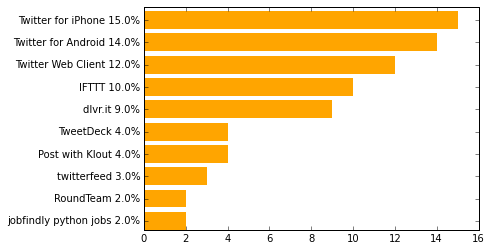

In [9]:
dataset.source_name = dataset.source.apply(get_source_name)

source_counts = dataset.source_name.value_counts().sort_values()[-10:]

bottom = [index for index, item in enumerate(source_counts.index)]
plt.barh(bottom, width=source_counts, color="orange", linewidth=0)

y_labels = ["%s %.1f%%" % (item, 100.0*source_counts[item]/len(dataset)) for index,item in enumerate(source_counts.index)]
plt.yticks(np.array(bottom)+0.4, y_labels)

source_counts